# SC qubits - testing the sc_qubits module

## Initialization (load modules etc.)

In [1]:
%pylab inline

from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import sc_qubits as qubit  # import the superconducting circuit module

from qutip import *
from sc_qubits import op, subtr_gnd, diag_hmltn, hbd

Populating the interactive namespace from numpy and matplotlib


## The Transmon and Cooper pair box

$H_\text{CPB}=4E_\text{C}(\hat{n}-n_g)^2+\frac{1}{2}E_\text{J}(|n\rangle\langle n+1|+\text{h.c.})$

In [3]:
CPB = qubit.QubitTransmon(
    EJ = 10.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 30
    )

In [3]:
CPB

QUBIT PARAMETERS -------
EC	: 1.0
EJ	: 10.0
_qubit_type	: Cooper pair box
ncut	: 30
ng	: 0.0


[====================] 100.0% Done.
Writing graphics and parameters to ./data/CPB_E_vs_ng.pdf and ./data/CPB_E_vs_ng.prm.


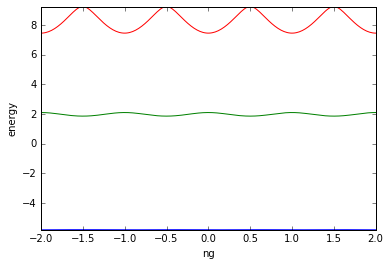

In [4]:
ng_list = np.linspace(-2, 2, 220)
CPB.plot_evals_vs_paramvals('ng', ng_list, evnum=3, subtract_ground=False, to_file="./data/CPB_E_vs_ng")


[====================] 100.0% Done.


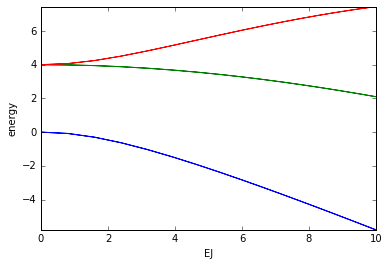

In [5]:
CPB.pm.ng = 0.0
ejvals = CPB.pm.EJ * np.cos(linspace(-pi/2, pi/2, 40))
CPB.plot_evals_vs_paramvals('EJ', ejvals, evnum=3, subtract_ground=False)

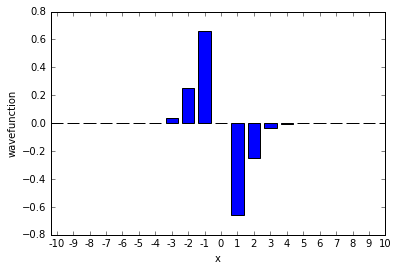

In [7]:
CPB.plot_wavefunction(esys=None, which=1, mode='real')

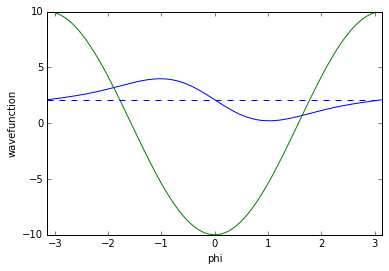

In [8]:
CPB.plot_wavefunction(basis='phase', esys=None, which=1, mode='real')

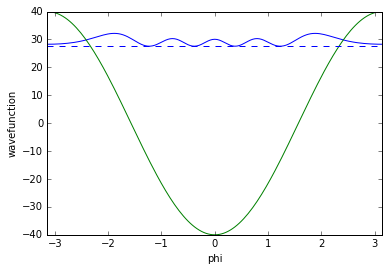

In [23]:
CPB.plot_wavefunction(basis='phase', esys=None, which=4, mode='abs2')

### Charge matrix elements

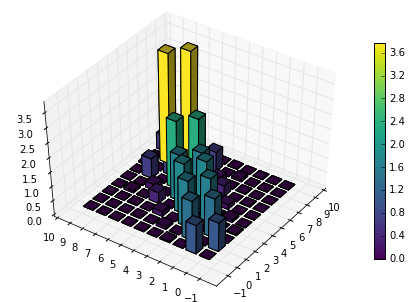

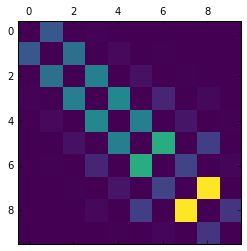

In [5]:
CPB.pm.EJ  = 40
CPB.pm.ncut = 60
nmat = CPB.matrixelements('n', esys=None, evnum=10)
qubit.plot_matrixelements(nmat, mode='abs')


## Fluxonium qubit

$H_\text{fl}=-4E_\text{C}\partial_\phi^2-E_\text{J}\cos(\phi-\varphi_\text{ext}) +\frac{1}{2}E_L\phi^2$

In [3]:
fluxonium = qubit.QubitFluxonium(
    EJ = 8.9,
    EC = 2.5,
    EL = 0.5,
    flux = 0.0,
    cutoff = 110
)

In [4]:
fluxonium

QUBIT PARAMETERS -------
EC	: 2.5
EJ	: 8.9
EL	: 0.5
_qubit_type	: fluxonium
cutoff	: 110
flux	: 0.0

In [5]:
fluxonium.eigenvals()

array([ -4.28338463,   4.47506063,   4.69616798,   6.71864972,
        12.64960539,  15.28847499])


[====================] 100.0% Done.


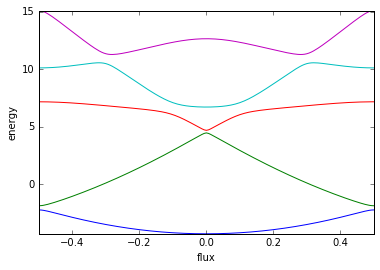

In [6]:
flux_list = np.linspace(-0.5, 0.5, 151)
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evnum=5)


[====================] 100.0% Done.


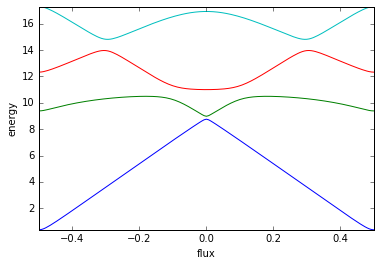

In [7]:
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evnum=5, subtract_ground=True)

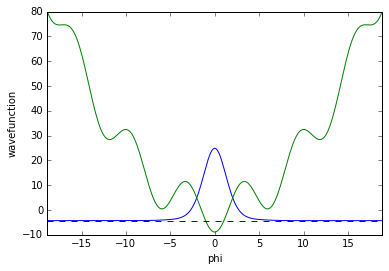

In [7]:
fluxonium.plot_wavefunction(esys=None, which=0, mode='real')

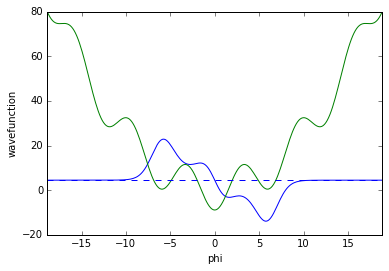

In [14]:
fluxonium.plot_wavefunction(esys=None, which=1, mode='real')

### Matrix elements

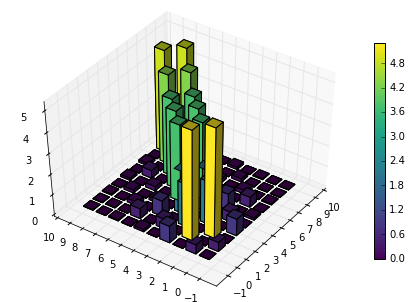

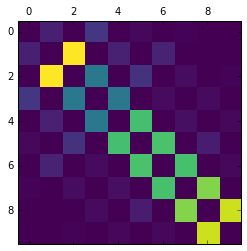

In [9]:
phimat = fluxonium.matrixelements('phi', esys=None, evnum=10)
qubit.plot_matrixelements(phimat)

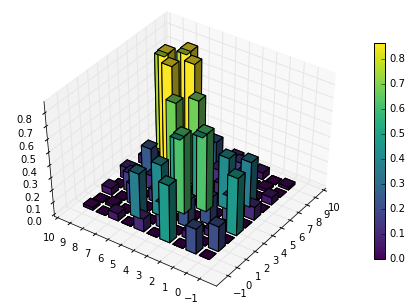

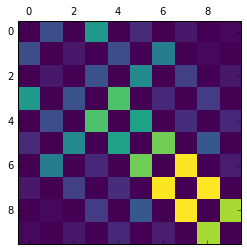

In [10]:
nmat = fluxonium.matrixelements('n', esys=None, evnum=10)
qubit.plot_matrixelements(nmat)

## Colormap Plots

### Example 1: Plotting eigenenergies with color determined by expectation value of eigenstate with a.dag()*a

In [2]:
#Setting up coupled qubit-resonator system

fluxonium = qubit.QubitFluxonium(
    EJ = 8.45,
    EC = 0.452,
    EL = 0.253,
    flux = 0.0,
    cutoff = 110,
    dim = 8
)

resonator = qubit.GenericQSys(dim=4)  # up to 3 photons (0,1,2,3)

hspc = (fluxonium, resonator)

a_res = destroy(resonator.dim)
a = op(a_res, resonator, hspc)

h_cpb1 = qubit.diag_hmltn(fluxonium)
h1 = op(h_cpb1, fluxonium, hspc)

omegar = 4.915  
g = 0.085  

def hamiltonian(flux):
    fluxonium.pm.flux = flux
    
    _, evecs = fluxonium.eigensys(fluxonium.dim)
    gmat = g * qubit.matrixelem_table(fluxonium.n(), evecs)   # coupling constants
    
    h1 = op(diag_hmltn(fluxonium), fluxonium, hspc)
    v = sum([gmat[j][k] * hbd(j,k,fluxonium,hspc) for j in range(fluxonium.dim) for k in range(fluxonium.dim)])
    
    return (h1 + omegar*a.dag()*a + v*(a + a.dag()))

In [3]:
#Obtaining data, in this case eigenvalues and eigenstates

flux_list = np.linspace(0, 1, 320)
eigvals = 11
eval_list = [subtr_gnd(hamiltonian(flux).eigenenergies(eigvals=eigvals)) for flux in flux_list]
estates_list = [hamiltonian(flux).eigenstates(eigvals=eigvals) for flux in flux_list]

In [12]:
x = flux_list
y = [[] for i in range(eigvals)]
for i in range(eigvals):
    for p in range(len(x)):
        y[i].append((eval_list[p])[i])  #Reshaping data to use in cmap_plot function

t = []
for p in range(eigvals):
    t.append([qutip.expect(a.dag()*a, estates_list[i][1][p]) for i in range(len(flux_list))])
    #Parameter determining the color of the plot. In this case, expectation value of the eigenstates
    ##of the coupled fluxonium-resonator system with a.dag()*a

In [6]:
def cmap_plot(x_param, x_list, y_param, y_vals, t_param, t_vals, norm_min, norm_max, x_min=False, x_max=False, y_min=False, y_max=False, colormap='jet', x_figsize=15, y_figsize=10, line_width=2):
    """Takes a list of x-values, 
    a list of lists with each element containing the y-values corresponding to a particular curve, 
    a list of lists with each element containing the external parameter value (t-value) 
    that determines the color of each curve at each y-value,
    and a normalization interval for the t-values."""
    y = []
    for i in range(len(y_vals)):
        for p in range(len(y_vals[i])):
            y.append(y_vals[i][p])
    fig = plt.figure(figsize=(x_figsize,y_figsize))
    for i in range(len(y_vals)):
        pts = np.array([x_list,y_vals[i]]).T.reshape(-1, 1, 2)
        segs = np.concatenate([pts[:-1],pts[1:]],axis=1)
        lc = LineCollection(segs, cmap=plt.get_cmap(colormap),norm=plt.Normalize(norm_min, norm_max))
        lc.set_array(np.array(t_vals[i]))
        lc.set_linewidth(line_width)
        plt.gca().add_collection(lc)
        
    plt.xlabel(x_param)
    if x_min and x_max:
        plt.xlim(x_min, x_max)
    elif x_min:
        plt.xlim(x_min, max(x_list))
    elif x_max:
        plt.xlim(min(x_list), x_max)
    else:
        plt.xlim(min(x_list), max(x_list))
        
    plt.ylabel(y_param)
    if y_min and y_max:
        plt.ylim(y_min, y_max)
    elif y_min:
        plt.ylim(y_min, max(y))
    elif y_max:
        plt.ylim(min(y), y_max)
    else:
        plt.ylim(min(y), max(y))
        
    axcb = fig.colorbar(lc)
    axcb.set_label(t_param)
    plt.show()

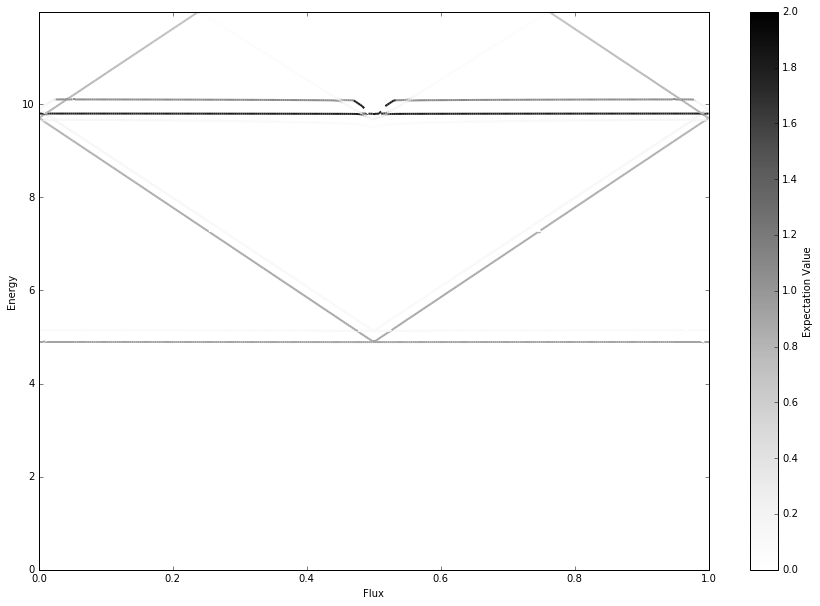

In [13]:
cmap_plot('Flux', x, 'Energy', y, 'Expectation Value', t, 0, 2, colormap='Greys')

### Example 2: Plotting eigenenergies with color determined by value charge matrix element for the transition from ground

In [8]:
flux_list = np.linspace(0, 1, 320)
eigvals = 11
eval_list = [subtr_gnd(hamiltonian(flux).eigenenergies(eigvals=eigvals)) for flux in flux_list]

In [9]:
#Obtaining data

x = flux_list
y = [[] for i in range(eigvals)]
for i in range(eigvals):
    for p in range(len(x)):
        y[i].append((eval_list[p])[i]) #Reshaping data

t = [[] for p in range(eigvals)]
for p in range(eigvals):
    for value in flux_list:
        fluxonium.pm.flux = value
        b = fluxonium.matrixelements('n', esys=None, evnum = eigvals)
        t[p].append((g * abs(b[0,p]) / ((y[p])[i] - (y[0])[i] - omegar)))

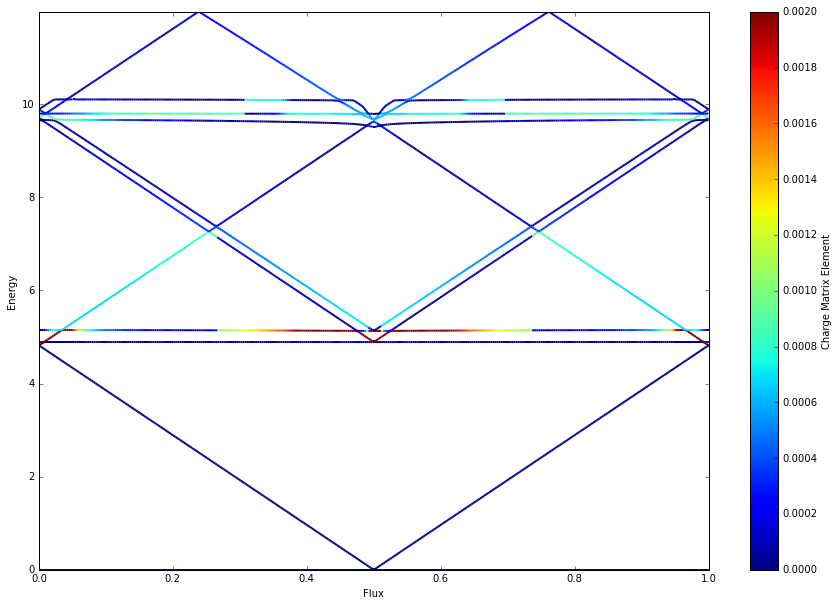

In [10]:
cmap_plot('Flux', x, 'Energy', y, 'Charge Matrix Element', t, 0, 0.0020)

## The symmetric $0-\pi$ qubit (no coupling to the $\chi$-mode)

$H_\text{sym}=-2E_\text{CJ}\partial_\phi^2-2E_{\text{C}\Sigma}\partial_\theta^2-2E_\text{J}\cos\theta\cos(\phi-\varphi_\text{ext}/2)+E_L\phi^2+2E_\text{J}$

In [2]:
# parameters for the 0-\pi circuit

EJ_CONST = 1/3.95  # note that EJ and ECJ are interrelated

zero_pi = qubit.QubitSymZeroPi(
    min_max_pts = np.asarray([ 
        [-12*pi, 12*pi, 300], # phi variable
        [-pi/2, 3*pi/2, 40]   # theta variable (2pi periodic!)
    ]),
    EJ   = EJ_CONST,
    EL   = 10.0**(-3),
    ECJ  = 1/(8.0*EJ_CONST),
    ECS  = 10.0**(-3),
    flux = 0
)    

In [3]:
zero_pi

QUBIT PARAMETERS -------
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
_qubit_type	: symmetric 0-Pi qubit (zero offset charge)
flux	: 0
min_max_pts	: [[ -37.69911184   37.69911184  300.        ]
 [  -1.57079633    4.71238898   40.        ]]

### Potential energy for symmetric 0-$\pi$ qubit

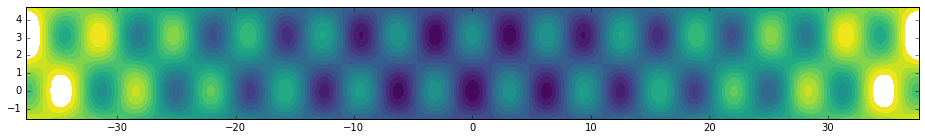

In [4]:
# zero_pi.plot_potential(levls=linspace(0,2,20), aspect_ratio=0.12, to_file="potential.pdf")
zero_pi.plot_potential(levls=linspace(0,2,20), aspect_ratio=0.12)

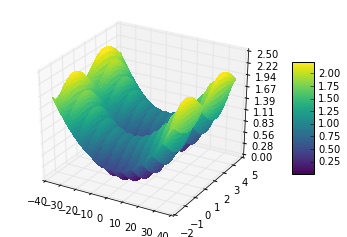

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.linspace(-37,37,300)
Y = np.linspace(-0.5*np.pi, 1.5*np.pi, 40)
X, Y = np.meshgrid(X, Y)
Z = zero_pi.potential(X,Y)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Current version of matplotlib does not appear to allow changing the aspect ratio of a 3d surface plot. (There's a development branch for that on github.) Will not implement this in the library for now.

### Eigenenergies

In [35]:
evals = zero_pi.eigenvals()

In [36]:
evals

array([ 0.42752059,  0.42848074,  0.45609018,  0.45690736,  0.46835442,
        0.4785273 ])


[====================] 100.0% Done.
Writing graphics and parameters to ./data/0pi_sym.pdf and ./data/0pi_sym.prm.


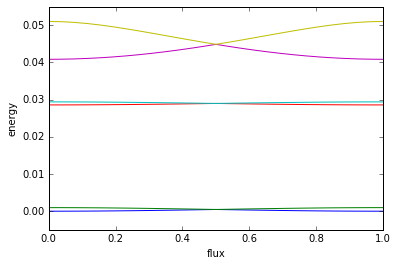

In [37]:
flux_list = np.linspace(0, 1, 27)
# zero_pi.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], to_file="./data/0pi_sym")
zero_pi.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], yrange=[-0.005,0.055], to_file="./data/0pi_sym")

In [13]:
evals1,evecs1 = zero_pi.eigensys()

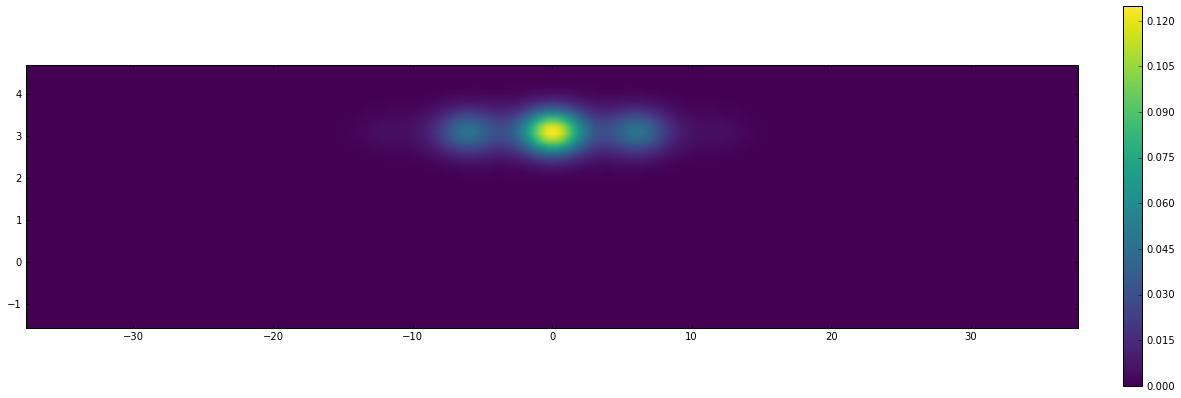

In [14]:
zero_pi.plot_wavefunction(esys=(evals1,evecs1), which=0, mode='abs')

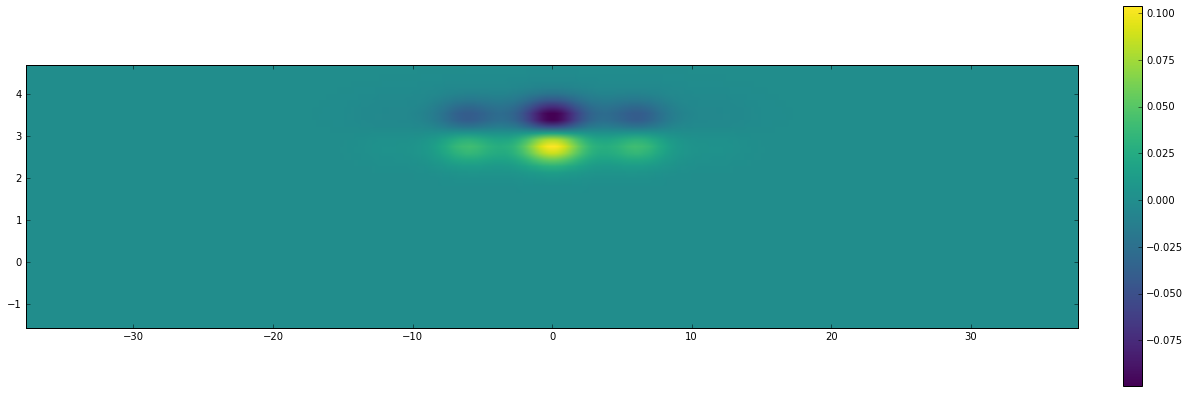

In [15]:
zero_pi.plot_wavefunction(esys=None, which=2, mode='real')

## The symmetric $0-\pi$ qubit with offset charge (no coupling to the $\chi$-mode)

$H_\text{sym}=-2E_\text{CJ}\partial_\phi^2+2E_{\text{C}\Sigma}(i\partial_\theta-n_g)^2-2E_\text{J}\cos\theta\cos(\phi-\varphi_\text{ext}/2)+E_L\phi^2+2E_\text{J}$

In [16]:
# parameters for the 0-\pi circuit

EJ_CONST = 1/3.95


zero_pi_ng = qubit.QubitSymZeroPiNg(
    min_max_pts = np.asarray([ 
        [-12*pi, 12*pi, 250], # phi variable
        [-pi/2, 3*pi/2, 50]   # theta variable (2pi periodic!)
    ]),
    EJ   = EJ_CONST,
    EL   = 10.0**(-3),
    ECJ  = 1/(8.0*EJ_CONST),
    ECS  = 10.0**(-3),
    flux = 0.25,
    ng   = 4.2
)

In [17]:
evals=zero_pi_ng.eigenvals()

In [18]:
evals

array([ 0.43065338,  0.43132523,  0.46102418,  0.46158792,  0.47255518,
        0.47938238])

Note: the range in $n_g$ that converges is intimately related to the grid spacing along the $\chi$ direction. To appreciate this, remember that wavefunctions for $n_g=0$ and $n_g=1$ are identical except additional phase wrapping for the latter. This phase wrapping becomes faster and faster with $n_g$. (Specifically, the phase factor is $e^{i n_g \chi}$.)


[====================] 100.0% Done.


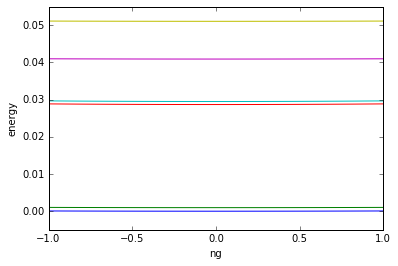

In [19]:
zero_pi_ng.pm.flux = 0.0
zero_pi_ng.pm.ng = 0.0

evals=zero_pi_ng.eigenvals(1)
ng_list = np.linspace(-1, 1, 12)
zero_pi_ng.plot_evals_vs_paramvals('ng', ng_list, shift=-evals[0], yrange=[-0.005,0.055])


### Plotting wave functions

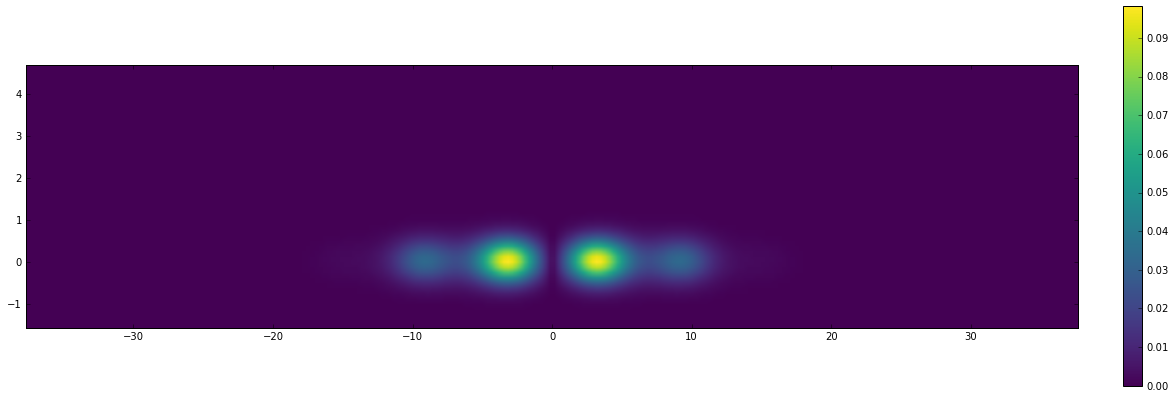

In [20]:
zero_pi_ng.pm.ng = 0.355
esys = zero_pi_ng.eigensys(10)

zero_pi_ng.plot_wavefunction(esys, which=4, mode='abs')

## The modified symmetric $0-\pi$ qubit: substitute inductors by Josephson junctions
(suggestion by Dave, not covered in paper)

$H_\text{mod} = -2E_{C\phi}\partial_\phi^2 -2E_{C\theta}\partial_\theta^2-2E_{C\chi}\partial_\theta^2-2E_J\cos(\theta+\varphi_\text{ext}/2)\cos\phi - 2E_{J}'\cos\chi\cos\phi$

In [20]:
# parameters for the modified 0-\pi circuit


#EJ    = 1/3.95
#EJp   = 10.0**(-3)
#ECphi = 1/(8.0*pm.EJ)
#ECth  = 10.0**(-3)
#ECchi = 10.0**(-3)
#flux = 0

mod_zeropi = qubit.QubitModZeroPi(
    min_max_pts = np.asarray([ 
        [-pi/2, 3*pi/2, 40], # phi variable (2pi periodic!)
        [-pi/2, 3*pi/2, 40], # theta variable (2pi periodic!)
        [-pi/2, 3*pi/2, 40], # chi variable (2pi periodic!)        
    ]),
    EJ    = 1.0,
    EJp   = 1.1,
    ECphi = 1.2,
    ECth  = 1.3,
    ECchi = 1.4,
    flux  = 0.1
)

Implementation of this 0-pi device variation is still experimental & not complete


In [21]:
mod_zeropi

QUBIT PARAMETERS -------
ECchi	: 1.4
ECphi	: 1.2
ECth	: 1.3
EJ	: 1.0
EJp	: 1.1
_qubit_type	: modified symmetric 0-Pi qubit (EL->EJp)
min_max_pts	: [[ -1.57079633   4.71238898  40.        ]
 [ -1.57079633   4.71238898  40.        ]
 [ -1.57079633   4.71238898  40.        ]]
pext	: 0.1

In [22]:
mod_zeropi.eigenvals(10)

array([ 3.77340045,  5.04567667,  6.48983467,  6.52864504,  6.7520074 ,
        6.82561228,  7.88700006,  7.99414245,  8.1649993 ,  8.37670102])

## The full $0−\pi$ qubit including disorder-induced coupling to χ-mode

$H = H_\text{sym}
+4E_{C\Sigma}(\delta C_J/C_J)\partial_\phi\partial_\theta +2\,\delta E_J \sin\theta\sin(\phi-\phi_\text{ext}/2)\\
\quad-2E_C\partial_\chi^2+E_L \chi^2+4E_{C\Sigma}(\delta C/C)\partial_\theta\partial_\chi+2\,\delta E_L \phi\, \chi$

### With disorder in all quantities

In [21]:
# parameters for the modified 0-\pi circuit
EJ_CONST  = 1/3.95
ECJ_CONST = 1/(8.0*EJ_CONST)
ECS_CONST = 10.0**(-3)

zeropi_full = qubit.QubitFullZeroPi(
    min_max_pts = np.asarray([ 
        [-7*pi, 7*pi, 65],   # phi variable
        [-pi/2, 3*pi/2, 35], # theta variable (2pi periodic!)
        [-10.0, 10.0, 70]    # chi variable
    ]),
    EJ  = EJ_CONST,
    dEJ = 0.05,
    EL  = 10.0**(-3),
    dEL = 0.05,
    ECJ = ECJ_CONST,
    dCJ = 0.05,
    ECS = ECS_CONST,
    EC  = 1/(1/ECS_CONST-1/ECJ_CONST),
    dC  = 0.08,
    flux = 0
)

In [22]:
zeropi_full

QUBIT PARAMETERS -------
EC	: 0.00100202942669
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
_qubit_type	: full 0-Pi circuit (phi, theta, chi), no offset charge
dC	: 0.08
dCJ	: 0.05
dEJ	: 0.05
dEL	: 0.05
flux	: 0
min_max_pts	: [[-21.99114858  21.99114858  65.        ]
 [ -1.57079633   4.71238898  35.        ]
 [-10.          10.          70.        ]]

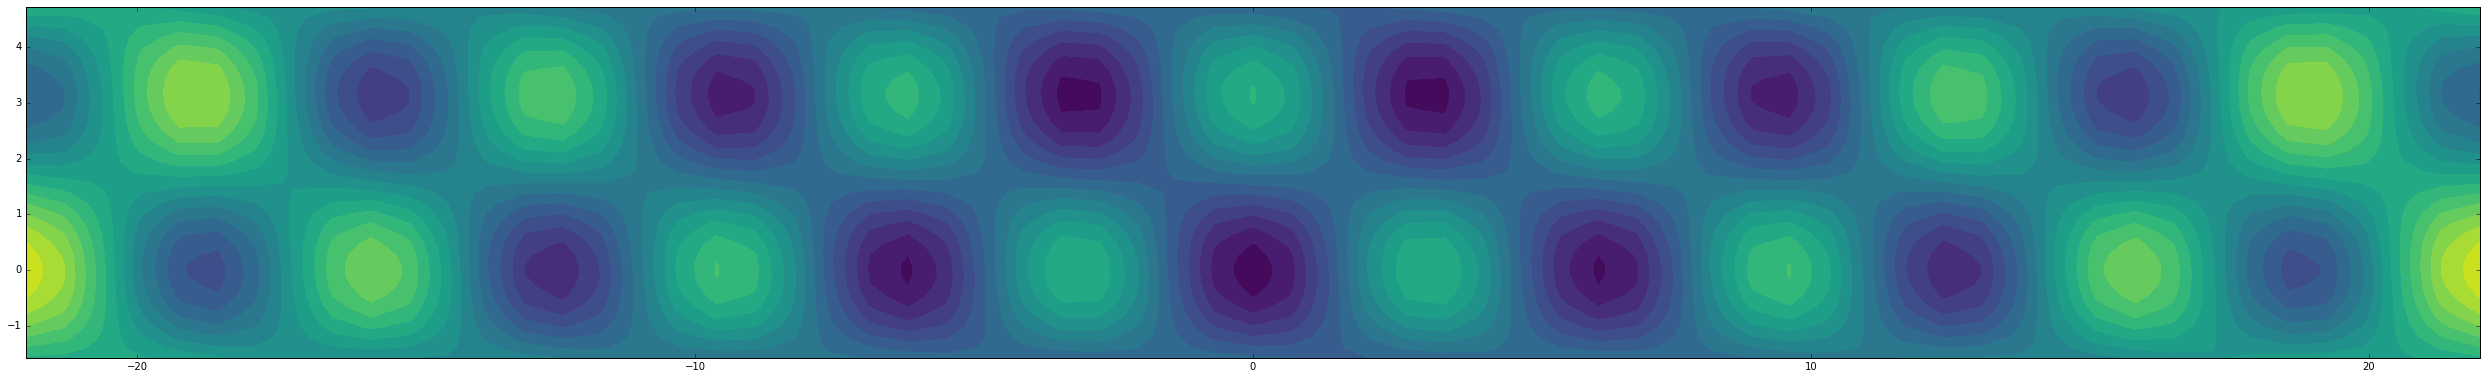

In [25]:
# zeropi_full.plot_potential('theta', 0.0, levls=linspace(0,1.63,20))
zeropi_full.plot_potential('chi', 0.0, levls=linspace(0,1.63,20))

In [23]:
ev0 = zeropi_full.eigenvals(evnum=2)
print(ev0[0])

0.453696754936



Percent: [====================] 100.0% Done.


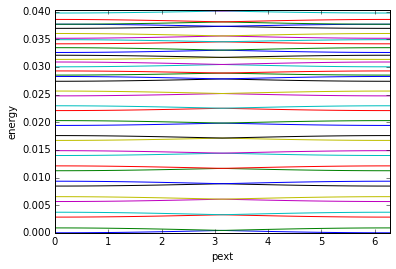

In [38]:
flux_list = np.linspace(0, 2*pi, 27)
zeropi_full.plot_evals_vs_paramvals('flux', flux_list, evnum=40, shift=-ev0[0],to_file="./data/0pifull_E_vs_flux")

In [24]:
# evals, evecs = zeropi_full.eigensys(40, to_file="./data/0pi_disordered")
evals, evecs = zeropi_full.eigensys(evnum=3)

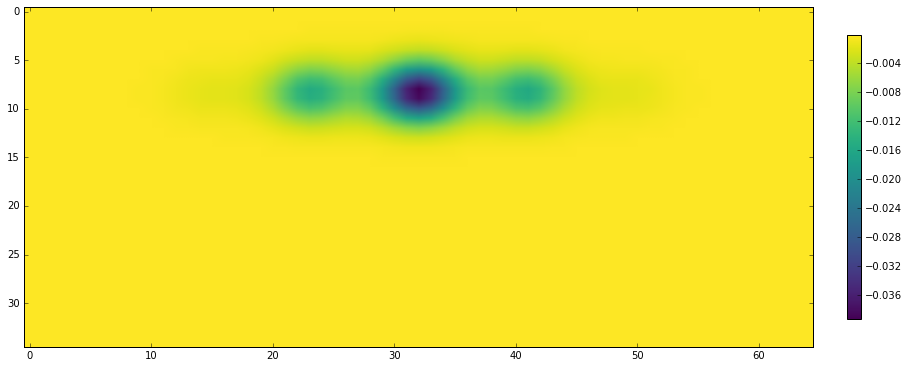

In [25]:
zeropi_full.plot_wavefunction(esys=(evals,evecs), which=2, mode='real', fixed_arg_key='chi', arg_const=-0.5, figsize=(15,15), aspect_ratio=0.8)

Note: for the parameters chosen here (and similar to what the "ideal" 0-pi device should have), it is evident that spatial discretization is problematic for the $\chi$ degree of freedom. This degree is so low-energetic that it will acquire a large number of nodes/antinodes before other excitations occur. These nodes/antinodes will be densely spaced, going beyond the spatial discretization and hence causing errors (seen as deviations from equidistant spacing of energy levels for the case without disorder).

### No disorder

In [28]:
# parameters for the modified 0-\pi circuit
EJ_CONST  = 1/3.95
ECJ_CONST = 1/(8.0*EJ_CONST)
ECS_CONST = 10.0**(-3)

zeropi_full = qubit.QubitFullZeroPi(
    min_max_pts = [ 
        [-7*pi, 7*pi, 65],  # phi variable
        [-pi/2, 3*pi/2, 35], # theta variable (periodic!)
        # [-8*pi, 8*pi, 45]   # chi variable   
        [-10.0, 10.0, 70]
    ],
    EJ  = EJ_CONST,
    dEJ = 0.0,
    EL  = 10.0**(-3),
    dEL = 0.0,
    ECJ = ECJ_CONST,
    dCJ = 0.0,
    ECS = ECS_CONST,
    EC  = 1/(1/ECS_CONST-1/ECJ_CONST),
    dC  = 0.0,
    flux = 0
)

In [29]:
zeropi_full

QUBIT PARAMETERS -------
EC	: 0.00100202942669
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
 variables min, max, pts: 	: [[-21.99114858  21.99114858  65.        ]
 [ -1.57079633   4.71238898  35.        ]
 [-10.          10.          70.        ]]
_qubit_type	: full 0-Pi circuit (phi, theta, chi), no offset charge
dC	: 0.0
dCJ	: 0.0
dEJ	: 0.0
dEL	: 0.0
pext	: 0


Percent: [====================] 100.0% Done.


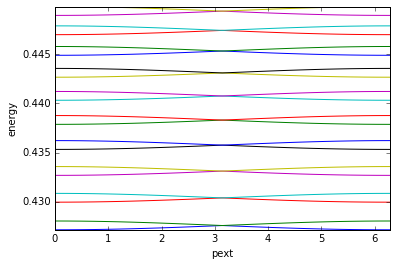

In [17]:
flux_list = np.linspace(0, 2*pi, 27)
zeropi_full.plot_evals_vs_paramvals('flux', flux_list, evnum=20, to_file="./data/0pifull_no_disorder_E_vs_flux")

In [18]:
evals, evecs = zeropi_full.eigensys(20, to_file="./data/0pi_no_disorder")

In [14]:
sqrt(8*pm.EC*pm.EL)

0.002831295712831086

## $0-\pi$ qubit with disorder in $E_J$ and $E_C$ ($\chi$ remains decoupled)

$H = H_\text{sym}
+4E_{C\Sigma}(\delta C_J/C_J)\partial_\phi\partial_\theta +2\,\delta E_J \sin\theta\sin(\phi-\phi_\text{ext}/2)$

In [44]:
# parameters
EJ_CONST = 1/3.95

zeropi_dis = qubit.QubitDisZeroPi(
    min_max_pts = np.asarray([ 
        [-8*pi, 8*pi, 360],  # phi variable
        [-pi/2, 3*pi/2, 55] # theta variable (periodic!)
    ]),
    EJ  = EJ_CONST,
    dEJ = 0.1,
    EL  = 10.0**(-3),
    ECJ = 1 / (8.0*EJ_CONST),
    dCJ = 0.1,
    ECS  = 10.0**(-3),
    flux = 0
)

In [45]:
zeropi_dis

QUBIT PARAMETERS -------
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
_qubit_type	: 0-Pi qubit with EJ and CJ disorder, no coupling to chi mode (zero offset charge)
dCJ	: 0.1
dEJ	: 0.1
flux	: 0
min_max_pts	: [[ -25.13274123   25.13274123  360.        ]
 [  -1.57079633    4.71238898   55.        ]]

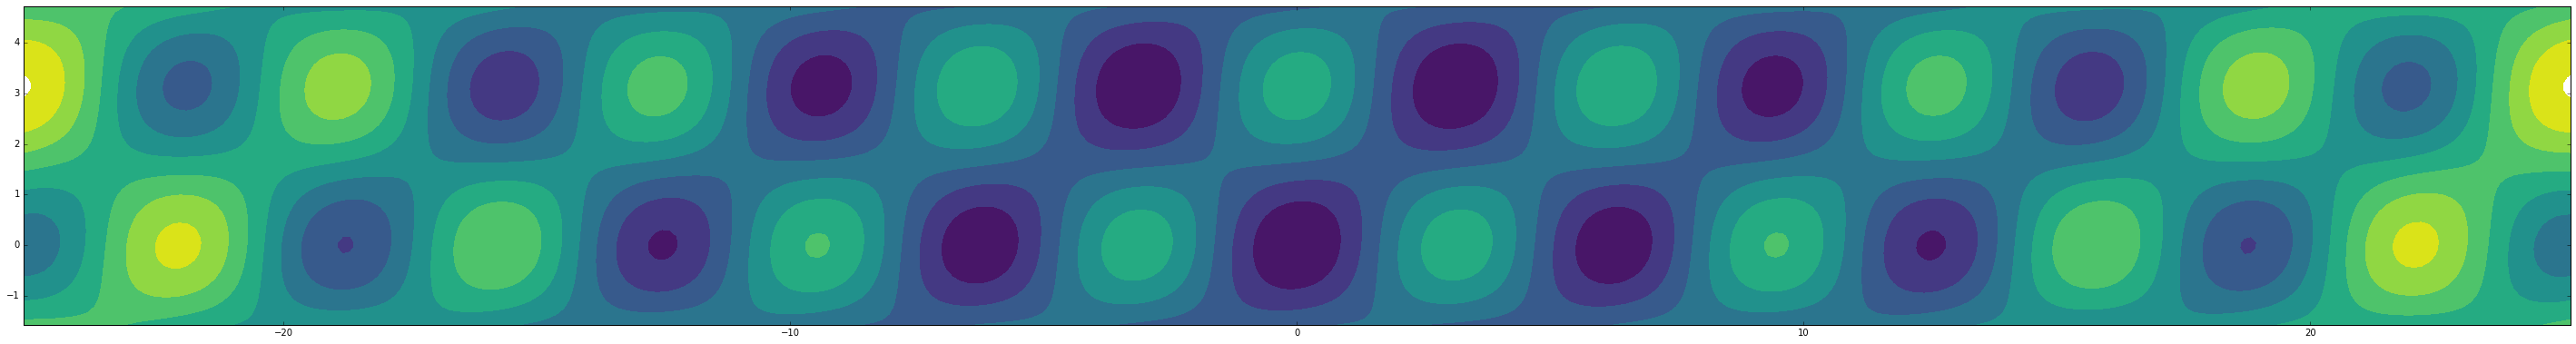

In [48]:
zeropi_dis.plot_potential(levls=linspace(0,1.63,10))

In [6]:
evals = zeropi_dis.eigenvals(evnum=4)
print evals


Percent: [====================] 100.0% Done.


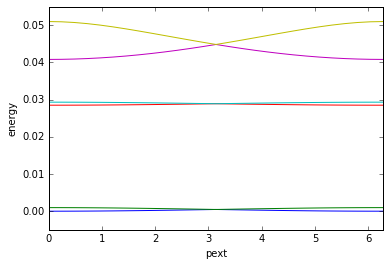

In [9]:
flux_list = np.linspace(0, 2*pi, 27)
zeropi_dis.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], yrange=[-0.005,0.055], to_file="./data/0pi_dis_E_vs_flux")

Note: as soon as $E_J$ disorder is included, the potential is not perfectly symmetric w.r.t. $\phi=0$ anymore, so small matrix elements between same-rung wavefunctions with nominally same parity are to be expected.

## Full $0-\pi$ circuit in product basis (all disorder types and coupling to $\chi$ mode)

In [49]:
# parameters for the modified 0-\pi circuit
EJ_CONST  = 1/3.95
ECJ_CONST = 1/(8.0*EJ_CONST)
ECS_CONST = 10.0**(-3)

zpifull = qubit.QubitFullZeroPi_ProductBasis(
    l_cut = 10,
    a_cut = 40,
    min_max_pts = np.asarray([ 
        # [-7*pi, 7*pi, 65],   # phi variable
        # [-pi/2, 3*pi/2, 35], # theta variable (2pi periodic!)
        [-8*pi, 8*pi, 360],  # phi variable
        [-pi/2, 3*pi/2, 55] # theta variable (periodic!)
    ]),
    EJ  = EJ_CONST,
    dEJ = 0.05,
    EL  = 10.0**(-3),
    dEL = 0.05,
    ECJ = ECJ_CONST,
    dCJ = 0.05,
    ECS = ECS_CONST,
    EC  = 1/(1/ECS_CONST-1/ECJ_CONST),
    dC  = 0.08,
    flux = 0
)

In [50]:
zpifull

QUBIT PARAMETERS -------
EC	: 0.00100202942669
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
_qubit_type	: full 0-Pi circuit (phi, theta, chi) in 0pi - chi product basis
a_cut	: 40
dC	: 0.08
dCJ	: 0.05
dEJ	: 0.05
dEL	: 0.05
flux	: 0
l_cut	: 10
min_max_pts	: [[ -25.13274123   25.13274123  360.        ]
 [  -1.57079633    4.71238898   55.        ]]

In [51]:
evals2 = zpifull.eigenvals(evnum=40)
evals2 - evals2[0]

array([ 0.        ,  0.00096136,  0.00281674,  0.00377643,  0.00563348,
        0.00659149,  0.00845022,  0.00940656,  0.01126697,  0.01222163,
        0.01408372,  0.0150367 ,  0.01690048,  0.01785177,  0.01971724,
        0.02066685,  0.022534  ,  0.02348193,  0.02535077,  0.02629701,
        0.02816754,  0.02861522,  0.02911209,  0.02942949,  0.03098432,
        0.03143511,  0.03192717,  0.03224512,  0.0338011 ,  0.03425501,
        0.03474226,  0.0350608 ,  0.03661789,  0.03707494,  0.03755735,
        0.03787651,  0.03943468,  0.03989488,  0.04037244,  0.04069226])

### Matrix elements $g_{ll'}$ [Dempster et al., text immediately above Eqs. (17) & (18)]

In [5]:
ev_num = 10
gmat = zpifull.g_coupling_matrix(None, evnum=ev_num)

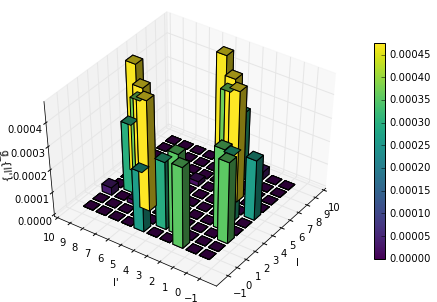

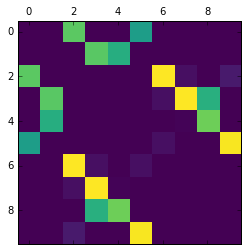

In [7]:
qubit.plot_matrixelements(gmat, xlabel="l", ylabel="l'", zlabel="g_{ll'}")

# Interfacing with qutip

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}\sum_{j,k}g^{(\alpha)}_{jk} |\alpha j\rangle \langle \alpha k|(a+a^\dagger)$

### Define Hilbert space components, Hilbert space tuple, and system operators

In [2]:
# Set up the components / subspaces of our Hilbert space
# Objects may be taken from sc_qubits; for resonators or other
# elements not covered, the class GenericQSys is provided in
# the qubitwrapper module

CPB1 = qubit.QubitTransmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.0,
    ncut = 40,
    dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.QubitTransmon(
    EJ = 3.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 10,
    dim = 3
)

resonator = qubit.GenericQSys(dim=4)  # up to 3 photons (0,1,2,3)


# Form a tuple of all components making up the Hilbert space. The ordering
# of the elements is fixed (crucial to keep unchanged so that tensor products
# are always consistent internally).
hspc = (CPB1, CPB2, resonator)


# First, define the annihilator for the resonator
# and then build up the full-system operator via tensor product with identities.
a_res = destroy(resonator.dim)
a = op(a_res, resonator, hspc)

# First, obtain the Qobj operator that has the eigenvalues of CPB1 on its diagonal,
# then build up the full-system operator via tensor product with identities.
h_cpb1 = diag_hmltn(CPB1)
h1 = op(h_cpb1, CPB1, hspc)

# Same for the second qubit CPB2.
h_cpb2 = diag_hmltn(CPB2)
h2 = op(h_cpb2, CPB2, hspc)

### Additional system parameters

In [3]:
omegar = 6.0  # resonator frequency
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

_, evecs1 = CPB1.eigensys(CPB1.dim)
_, evecs2 = CPB2.eigensys(CPB2.dim)
gmat1 = g1 * qubit.matrixelem_table(CPB1.n(), evecs1)   # coupling constants for CPB1
gmat2 = g2 * qubit.matrixelem_table(CPB2.n(), evecs2)   # and for CPB2


In [4]:
hamiltonian0 = h1 + h2 + omegar*a.dag()*a

vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1,hspc) for j in range(CPB1.dim) for k in range(CPB1.dim)])
vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2,hspc) for j in range(CPB2.dim) for k in range(CPB2.dim)])

hamiltonian1 = (vcpb1 + vcpb2) * (a + a.dag())

hamiltonian = hamiltonian0 + hamiltonian1

In [5]:
evals = hamiltonian.eigenenergies()
evals - evals[0]

array([  0.        ,   4.74135374,   5.67739078,   5.98951149,
         7.80640356,  10.72322011,  11.66031282,  11.97899879,
        12.54774148,  13.48377905,  13.7933695 ,  15.40788826,
        16.7053723 ,  17.64336196,  17.97765919,  18.52707416,
        19.46416567,  19.78143667,  20.14938352,  21.08528186,
        21.4445612 ,  22.73479033,  23.66005121,  24.50778023,
        25.44604089,  25.73329938,  26.1786433 ,  27.11548545,
        27.47977185,  30.48967409,  31.41501096,  32.20631984,
        33.14476367,  33.40597339,  38.16294583,  39.08803142])

In [8]:
# Example: spectrum when varying the Josephson energy of CPB1 via a flux
# Set up Hamiltonian:

ham0 = h2 + omegar*a.dag()*a

vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2,hspc) for j in range(CPB2.dim) for k in range(CPB2.dim)])




def hamiltonian(flux):
    CPB1.pm.EJ = 40.0 * cos(pi*flux)
    
    h_cpb1 = diag_hmltn(CPB1)
    h1 = op(h_cpb1, CPB1, hspc)
    vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1,hspc) for j in range(CPB1.dim) for k in range(CPB1.dim)])
    
    return (h1 + ham0 + (vcpb1 + vcpb2) * (a + a.dag()))



In [9]:
flux_list = np.linspace(0, 1, 320)
eigvals = 10
eval_list = [subtr_gnd(hamiltonian(flux).eigenenergies(eigvals=eigvals)) for flux in flux_list]

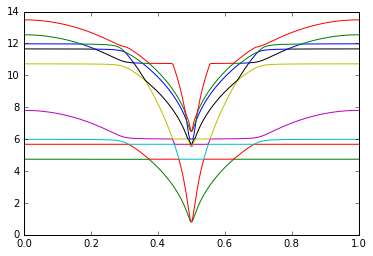

In [10]:
plt.plot(flux_list, eval_list)
plt.show()

In [25]:
flux_list = np.linspace(0.3, 0.4, 320)
eigvals = 4
eval_list = [subtr_gnd(hamiltonian(flux).eigenenergies(eigvals=eigvals)) for flux in flux_list]

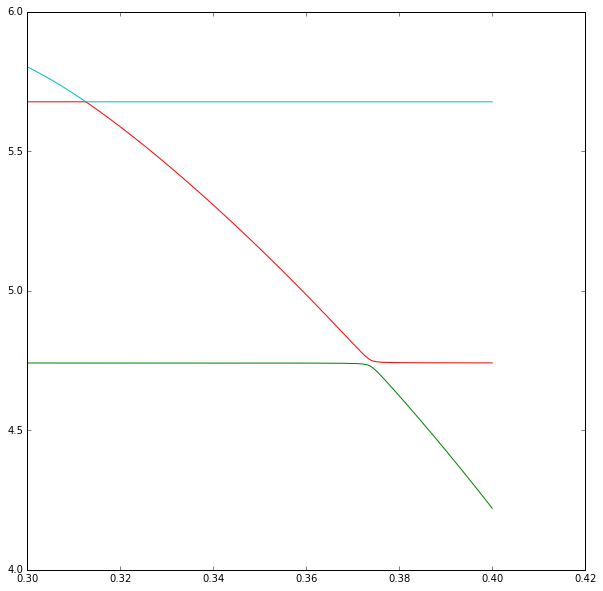

In [27]:
plt.plot(flux_list, eval_list)
plt.ylim(4,6)
plt.show()